<a href="https://colab.research.google.com/github/siddhu146/Rock-Papper-Scissor/blob/main/mnist_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $ Importing  \, Dependencies$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow_datasets as tfds
from collections import defaultdict
import random
import shutil
import time
from imageio import imwrite

#$ Loading \, Dataset$#

In [2]:
(ds_train,ds_test),ds_info = tfds.load("mnist",
                                       split=['train','test'],
                                       shuffle_files=True,
                                       as_supervised=True,with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.E0FO16_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.E0FO16_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


#$Preprocessing $#

In [3]:
batch_size = 64
def preprocess(img,label):
  return (tf.divide(tf.cast(img,tf.float32),tf.constant(255.0)),
          tf.one_hot(label,depth=10))

ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.map(preprocess,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache('./traindata')
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.map(
    preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache('./testdata')
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/My Drive/deepxplore/models/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

Mounted at /content/drive


# $LeNet-5$

In [6]:
def lenet5(input_tensor):
    """
    Creates a LeNet-5 model

    Arguments:
    input_tensor: tf.keras.Input() layer with input dimensions (28, 28, 1)
    """
    x = tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1,
                               padding='valid', activation='tanh')(input_tensor)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1,
                               padding='valid', activation='tanh')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dense(120, activation='tanh')(x)
    x = tf.keras.layers.Dense(84, activation='tanh')(x)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor,
                                  outputs=output_layer,
                                  name='LeNet-5')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# $LeNet-1$

In [7]:
def lenet1(input_tensor):
    """
    Creates a LeNet-1 model.
    Arguments:
        input_tensor: tf.keras.Input() layer with input shape (e.g., (28,28,1))
    """
    x = tf.keras.layers.Conv2D(filters=4, kernel_size=5, strides=1,
                               padding='valid', activation='tanh')(input_tensor)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(12, kernel_size=5, strides=1,
                               activation='tanh', padding='valid')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Flatten(name='flatten')(x)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor,
                                  outputs=output_layer,
                                  name='LeNet-1')

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# $LeNet-4$

In [8]:
def lenet4(input_tensor):
    """
    Creates a LeNet-4 model.
    Arguments:
        input_tensor: tf.keras.Input() layer with input shape (e.g., (28,28,1))
    """
    x = tf.keras.layers.Conv2D(filters=4, kernel_size=5, strides=1,
                               padding='valid', activation='tanh')(input_tensor)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=5, strides=1,
                               activation='tanh', padding='valid')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dense(120, activation='tanh')(x)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor,
                                  outputs=output_layer,
                                  name='LeNet-4')

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# $ Training \, the \, models $#

Model: "LeNet-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 12, 12, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 4, 4, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,426 (173.54 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8429 - loss: 0.5323
Epoch 1: val_loss improved from inf to 0.12369, saving model to lenet5.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8430 - loss: 0.5320 - val_accuracy: 0.9611 - val_loss: 0.1237
Epoch 2/20
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9641 - loss: 0.1177
Epoch 2: val_loss improved from 0.12369 to 0.07641, saving model to lenet5.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9641 - loss: 0.1176 - val_accuracy: 0.9752 - val_loss: 0.0764
Epoch 3/20
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9775 - loss: 0.0744
Epoch 3: val_loss improved from 0.07641 to 0.05841, saving model to lenet5.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9775 - loss: 0.0744 - val_accuracy: 0.9807 - val_loss: 0.0584
Epoch 4/20
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9826 - loss: 0.0568
Epoch 4: val_loss improved from 0.05841 to 0.05233

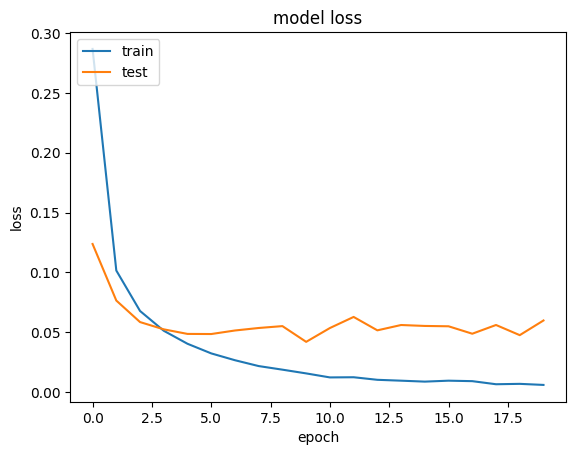

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0509
test accuracy: [0.05973769351840019, 0.9855999946594238]


In [9]:
model = lenet5(tf.keras.Input(shape=(28,28,1,)))
#modelsummary
model.summary()
#callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='lenet5.best.keras',
    verbose=1,
    save_best_only=True
)

# Train the model on all available devices.
history=model.fit(ds_train, epochs=20, validation_data=ds_test,
                    verbose=1,callbacks=[checkpointer])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
eval = model.evaluate(ds_test, verbose = 1)
print("test accuracy:", eval)

Model: "LeNet-4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 12, 12, 4)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 16)       │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 4, 4, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,770 (131.91 KB)

 Trainable params: 33,770 (131.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8502 - loss: 0.5422
Epoch 1: val_loss improved from inf to 0.13436, saving model to lenet4.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8503 - loss: 0.5419 - val_accuracy: 0.9605 - val_loss: 0.1344
Epoch 2/20
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9614 - loss: 0.1282
Epoch 2: val_loss improved from 0.13436 to 0.08233, saving model to lenet4.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9614 - loss: 0.1281 - val_accuracy: 0.9743 - val_loss: 0.0823
Epoch 3/20
920/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9752 - loss: 0.0819
Epoch 3: val_loss improved from 0.08233 to 0.06283, saving model to lenet4.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9753 - loss: 0.0818 - val_accuracy: 0.9798 - val_loss: 0.0628
Epoch 4/20
925/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0613
Epoch 4: val_loss improved from 0.06283 to 0.05318,

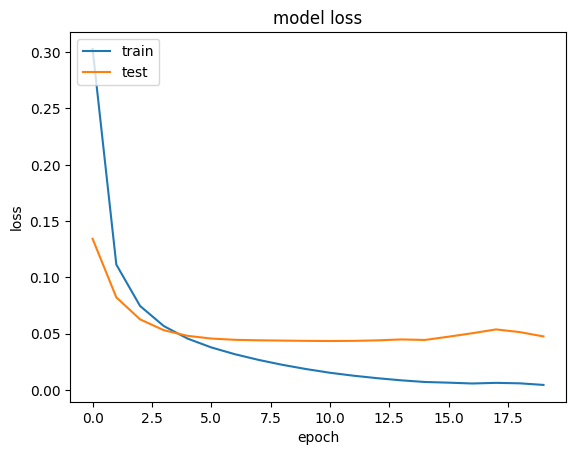

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0418
test accuracy: [0.04765372723340988, 0.9876000285148621]


In [10]:
model = lenet4(tf.keras.Input(shape=(28,28,1,)))
#modelsummary
model.summary()
#callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='lenet4.best.keras',
    verbose=1,
    save_best_only=True
)

# Train the model on all available devices.
history=model.fit(ds_train, epochs=20, validation_data=ds_test,
                    verbose=1,callbacks=[checkpointer])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
eval = model.evaluate(ds_test, verbose = 1)
print("test accuracy:", eval)

Model: "LeNet-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 12, 12, 4)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 12)       │         1,212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 4, 4, 12)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,246 (12.68 KB)

 Trainable params: 3,246 (12.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7526 - loss: 0.8790
Epoch 1: val_loss improved from inf to 0.21985, saving model to lenet1.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7527 - loss: 0.8786 - val_accuracy: 0.9374 - val_loss: 0.2198
Epoch 2/20
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.2116
Epoch 2: val_loss improved from 0.21985 to 0.13553, saving model to lenet1.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9393 - loss: 0.2114 - val_accuracy: 0.9601 - val_loss: 0.1355
Epoch 3/20
916/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9594 - loss: 0.1401
Epoch 3: val_loss improved from 0.13553 to 0.09962, saving model to lenet1.best.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9595 - loss: 0.1398 - val_accuracy: 0.9721 - val_loss: 0.0996
Epoch 4/20
926/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9686 - loss: 0.1081
Epoch 4: val_loss improved from 0.09962 to 0.07997,

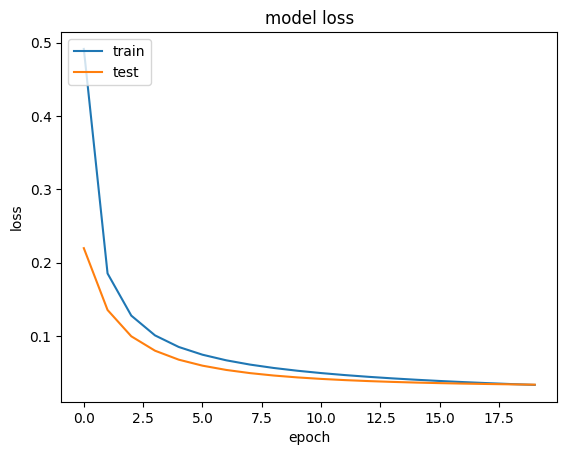

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0294
test accuracy: [0.03366168960928917, 0.9891999959945679]


In [11]:
model = lenet1(tf.keras.Input(shape=(28,28,1,)))
#modelsummary
model.summary()
#callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='lenet1.best.keras',
    verbose=1,
    save_best_only=True
)

# Train the model on all available devices.
history=model.fit(ds_train, epochs=20, validation_data=ds_test,
                    verbose=1,callbacks=[checkpointer])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
eval = model.evaluate(ds_test, verbose = 1)
print("test accuracy:", eval)

In [15]:

dest_dir = '/content/drive/My Drive/deepxplore/models/'

for filename in ['lenet5.best.keras', 'lenet4.best.keras', 'lenet1.best.keras']:
    src = f'/content/{filename}'
    dst = os.path.join(dest_dir, filename)

    # Remove the file if it already exists
    if os.path.exists(dst):
        os.remove(dst)

    # Move the file
    shutil.move(src, dst)
    print(f"Moved: {src} → {dst}")

Moved: /content/lenet5.best.keras → /content/drive/My Drive/deepxplore/models/lenet5.best.keras
Moved: /content/lenet4.best.keras → /content/drive/My Drive/deepxplore/models/lenet4.best.keras
Moved: /content/lenet1.best.keras → /content/drive/My Drive/deepxplore/models/lenet1.best.keras


#$DeepXplore$#

In [16]:
input_tensor = tf.keras.layers.Input(shape=(28, 28, 1), name = 'input')
model1 = lenet5(input_tensor= input_tensor)
model2 = lenet4(input_tensor= input_tensor)
model3 = lenet1(input_tensor= input_tensor)

In [17]:
model1.load_weights('/content/drive/My Drive/deepxplore/models/lenet5.best.keras')
model2.load_weights('/content/drive/My Drive/deepxplore/models/lenet4.best.keras')
model3.load_weights('/content/drive/My Drive/deepxplore/models/lenet1.best.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#storing the information of models in dictionaries
def init_coverage_tables(model1, model2, model3):
  """
  Initialiizes a dictionary with defaultdict, for each neuron (keeps note of its activation)\n
  Arguements: models to be tested
  """
  model_layer_dict1 = defaultdict(bool)
  model_layer_dict2 = defaultdict(bool)
  model_layer_dict3 = defaultdict(bool)
  init_dict(model1, model_layer_dict1)
  init_dict(model2, model_layer_dict2)
  init_dict(model3, model_layer_dict3)
  return model_layer_dict1, model_layer_dict2, model_layer_dict3

In [ ]:
#creating dictionary
def init_dict(model, model_layer_dict):
  """
  Makes use of the initialised dictionary, creates a key-value pair for each neuron (along with layer name) \n
  Initially the value for each neuron is False i.e. inactive \n
  Arguements: models to be tested, dictionaries initialiased for keeping note of coverage
  """
  for layer in model.layers:
    if 'flatten' in layer.name or 'input' in layer.name:
      continue
    for index in range(layer.output_shape[-1]):
      model_layer_dict[(layer.name, index)] = False

In [ ]:
"""
creating a intermediate layer model for model1
It gives us access to output of every layer
"""
layer_names = [layer.name for layer in model1.layers if
               'flatten' not in layer.name and 'input' not in layer.name]
intermediate_layer_model1=tf.keras.models.Model(inputs=model1.input,
                                                outputs=[model1.get_layer(layer_name).output for layer_name in layer_names])

In [ ]:
"""
creating a intermediate layer model for model2
It gives us access to output of every layer
"""
layer_names = [layer.name for layer in model2.layers if
               'flatten' not in layer.name and 'input' not in layer.name]
intermediate_layer_model2=tf.keras.models.Model(inputs=model2.input,
                                                outputs=[model2.get_layer(layer_name).output for layer_name in layer_names])

In [ ]:
"""
creating a intermediate layer model for model3
It gives us access to output of every layer
"""
layer_names = [layer.name for layer in model3.layers if
               'flatten' not in layer.name and 'input' not in layer.name]
intermediate_layer_model3=tf.keras.models.Model(inputs=model3.input,
                                                outputs=[model3.get_layer(layer_name).output for layer_name in layer_names])

In [ ]:
#scaling the output of each neuron between 0 and 1
def scale(intermediate_layer_output, rmax=1, rmin=0):
  """
  scales output of each neuron according to minimum and maximum output of the neurons of the same layer \n
  Arguements: intermediate layer output i.e. list of output of a particular layer
  """
  X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
      intermediate_layer_output.max() - intermediate_layer_output.min())
  X_scaled = X_std * (rmax - rmin) + rmin
  return X_scaled

In [ ]:
def update_coverage(input_data, model, model_layer_dict, threshold=0):
  """
  updates the coverage dictionary \n
  compares the scaled output of each neuron with threshold \n
  Arguements: input_data- input image, model- model under testing, \n
              model_layer_dict- dictionary for that model \n
              threshold- threshold set by us
  """
  layer_names = [layer.name for layer in model.layers if
                 'flatten' not in layer.name and 'input' not in layer.name]
  if model==model1:
    intermediate_layer_model=intermediate_layer_model1
  elif model==model2:
    intermediate_layer_model=intermediate_layer_model2
  elif model ==model3:
    intermediate_layer_model=intermediate_layer_model3

  intermediate_layer_outputs = intermediate_layer_model.predict(input_data)
  for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
    scaled = scale(intermediate_layer_output[0])
    for num_neuron in range(scaled.shape[-1]):
      if np.mean(scaled[..., num_neuron]) > threshold and not model_layer_dict[(layer_names[i], num_neuron)]:
        model_layer_dict[(layer_names[i], num_neuron)] = True

In [ ]:
#finding the number of covered neurons by the test set
def neuron_covered(model_layer_dict):
  """
  gives us the number and percentage of neurons covered
  Arguements: model_layer_dict- coverage dictionary of that model
  """
  covered_neurons = len([v for v in model_layer_dict.values() if v])
  total_neurons = len(model_layer_dict)
  return covered_neurons, total_neurons, covered_neurons / float(total_neurons)

# $Initial \, Neuron  \, Coverage $#

In [ ]:
# initialize the neuron coverage tables/dictionaries.
model1_table,model2_table,model3_table = init_coverage_tables(model1,model2,model3)

In [ ]:
start_time = time.time()
images_checked = 0
threshold = 0.5
for testbatch,_ in ds_test:
  for testimg in testbatch:
    testimg = tf.expand_dims(testimg, axis= 0)
    update_coverage(testimg, model1, model1_table, threshold)
    update_coverage(testimg, model2, model2_table, threshold)
    update_coverage(testimg, model3, model3_table, threshold)
    coveredneurons1,totalneurons1,neuron_coverage1 = neuron_covered(model1_table)
    coveredneurons2,totalneurons2,neuron_coverage2 = neuron_covered(model2_table)
    coveredneurons3,totalneurons3,neuron_coverage3 = neuron_covered(model3_table)
    images_checked += 1
  print("Images checked: ", images_checked, "neuron coverage till now: ", neuron_coverage1*100,"%, ", neuron_coverage2*100,"%, ", neuron_coverage3*100,"%")
  print('model1:', model1.name, 'covered neurons:', coveredneurons1 , "total number of neurons:", totalneurons1)
  print('model2:', model2.name, 'covered neurons:', coveredneurons2 , "total number of neurons:", totalneurons2)
  print('model3:', model3.name, 'covered neurons:', coveredneurons3 , "total number of neurons:", totalneurons3)
print("--- %s total time ---" % (time.time() - start_time))

Images checked:  512 neuron coverage till now:  100.0 %,  97.6470588235294 %,  95.23809523809523 %
model1: LeNet-5 covered neurons: 258 total number of neurons: 258
model2: LeNet-4 covered neurons: 166 total number of neurons: 170
model3: LeNet-1 covered neurons: 40 total number of neurons: 42
Images checked:  1024 neuron coverage till now:  100.0 %,  97.6470588235294 %,  95.23809523809523 %
model1: LeNet-5 covered neurons: 258 total number of neurons: 258
model2: LeNet-4 covered neurons: 166 total number of neurons: 170
model3: LeNet-1 covered neurons: 40 total number of neurons: 42
Images checked:  1536 neuron coverage till now:  100.0 %,  98.82352941176471 %,  95.23809523809523 %
model1: LeNet-5 covered neurons: 258 total number of neurons: 258
model2: LeNet-4 covered neurons: 168 total number of neurons: 170
model3: LeNet-1 covered neurons: 40 total number of neurons: 42
Images checked:  2048 neuron coverage till now:  100.0 %,  98.82352941176471 %,  95.23809523809523 %
model1: LeN

In [ ]:
# initialize the neuron coverage tables/dictionaries.
model1_table,model2_table,model3_table = init_coverage_tables(model1,model2,model3)

In [ ]:
start_time = time.time()
images_checked = 0
threshold = 0.75
for testbatch,_ in ds_test:
  for testimg in testbatch:
    testimg = tf.expand_dims(testimg, axis= 0)
    update_coverage(testimg, model1, model1_table, threshold)
    update_coverage(testimg, model2, model2_table, threshold)
    update_coverage(testimg, model3, model3_table, threshold)
    coveredneurons1,totalneurons1,neuron_coverage1 = neuron_covered(model1_table)
    coveredneurons2,totalneurons2,neuron_coverage2 = neuron_covered(model2_table)
    coveredneurons3,totalneurons3,neuron_coverage3 = neuron_covered(model3_table)
    images_checked += 1
  print("Images checked: ", images_checked, "neuron coverage till now: ", neuron_coverage1*100,"%, ", neuron_coverage2*100,"%, ", neuron_coverage3*100,"%")
  print('model1:', model1.name, 'covered neurons:', coveredneurons1 , "total number of neurons:", totalneurons1)
  print('model2:', model2.name, 'covered neurons:', coveredneurons2 , "total number of neurons:", totalneurons2)
  print('model3:', model3.name, 'covered neurons:', coveredneurons3 , "total number of neurons:", totalneurons3)
print("--- %s total time ---" % (time.time() - start_time))

Images checked:  512 neuron coverage till now:  86.04651162790698 %,  82.35294117647058 %,  38.095238095238095 %
model1: LeNet-5 covered neurons: 222 total number of neurons: 258
model2: LeNet-4 covered neurons: 140 total number of neurons: 170
model3: LeNet-1 covered neurons: 16 total number of neurons: 42
Images checked:  1024 neuron coverage till now:  86.04651162790698 %,  82.35294117647058 %,  38.095238095238095 %
model1: LeNet-5 covered neurons: 222 total number of neurons: 258
model2: LeNet-4 covered neurons: 140 total number of neurons: 170
model3: LeNet-1 covered neurons: 16 total number of neurons: 42
Images checked:  1536 neuron coverage till now:  86.04651162790698 %,  83.52941176470588 %,  38.095238095238095 %
model1: LeNet-5 covered neurons: 222 total number of neurons: 258
model2: LeNet-4 covered neurons: 142 total number of neurons: 170
model3: LeNet-1 covered neurons: 16 total number of neurons: 42
Images checked:  2048 neuron coverage till now:  86.04651162790698 %,  

# $Corner \, case \, generation $#

In [ ]:
for layer in model1.layers:
  layer._name = "model1_"+layer.name
  print(layer.name)

model1_input
model1_conv2d
model1_average_pooling2d
model1_conv2d_1
model1_average_pooling2d_1
model1_flatten
model1_dense
model1_dense_1
model1_dense_2


In [ ]:
for layer in model2.layers:
  layer._name = "model2_"+layer.name
  print(layer.name)

model2_model1_input
model2_conv2d_2
model2_average_pooling2d_2
model2_conv2d_3
model2_average_pooling2d_3
model2_flatten
model2_dense_3
model2_dense_4


In [ ]:
for layer in model3.layers:
    layer._name = "model3_"+layer.name
    print(layer.name)

model3_model2_model1_input
model3_conv2d_4
model3_average_pooling2d_4
model3_conv2d_5
model3_average_pooling2d_5
model3_flatten
model3_dense_5


In [ ]:
model1.get_layer('model1_dense_1')._name = "model1_"+'before_softmax'
model2.get_layer('model2_dense_3')._name = "model2_"+'before_softmax'
model3.get_layer('model3_dense_5')._name = "model3_"+'before_softmax'
model3.get_layer('model3_model2_model1_input')._name = "input"

In [ ]:
#finding the neurons which have'nt been covered
def neuron_to_cover(model_layer_dict):
  """
  gives layer name and index of a random neuron which hads not been covered \n
  Arguements: model_layer_dict- model table/dictionary of neurons
  """
  not_covered = [(layer_name, index) for (layer_name, index), v in model_layer_dict.items() if not v]
  if not_covered:
   layer_name, index = random.choice(not_covered)
  else:
    layer_name, index = random.choice(list(model_layer_dict.keys()))
  return layer_name, index

In [ ]:
#deprocessing the generated image
def deprocess_image(x):
  """
  deprocesses the image to uint8 \n
  Arguements: x- generated image
  """
  x *= 255
  x = tf.cast(tf.clip_by_value(x, clip_value_min= 0, clip_value_max= 255), dtype= tf.uint8)     #clipping the values of generated output to 0 and 255
  return tf.reshape(x, [28,28,1])

In [ ]:
def normalize(y):
  """
  normalizing the gradients \n
  Arguements: y-obtained gradients of the original image
  """
  # utility function to normalize a tensor by its L2 norm
  for x in y:
    x = tf.divide(x, tf.add(tf.math.sqrt(tf.math.reduce_mean(tf.math.square(x))), tf.constant(1e-5)))
  return y

In [ ]:
def constraint_black(gradients, rect_shape=(2, 2)):
  """
  This contraint simulates the effect of dust on camera lenses \n
  takes in the gradient and selects a random patch \n
  if the mean of the gradients of that patch is less than zero \n
  then that patch in input image is blacked out \n
  \n
  Arguements: gradients- obtained gradients for the input image
              rect_shape- tuple, the size of blackout
  """
  start_point = (
         random.randint(0, gradients.shape[1] - rect_shape[0]),
         random.randint(0, gradients.shape[2] - rect_shape[1])
         )

  new_grads = np.zeros_like(gradients)
  patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
  if np.mean(patch) < 0:
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
  return new_grads

In [ ]:
def constraint_light(gradients):
  """
  This simulates different lighting conditions at which the target model\n
  fails to classify. \n
  this takes in the obtained gradients and computes the mean of it, \n
  then this mean is added to each and every pixel of the image. \n
  Arguements: gradients- obtained gradients of the input image
  """
  new_grads = np.ones_like(gradients)
  grad_mean = np.mean(gradients)
  return grad_mean * new_grads

In [ ]:
def constraint_occl(gradients, start_point, rect_shape):
  """
  This simulates the effect of an attacker blocking a patch \n
  to change the prediction of the input image \n
  this takes in the gradients and directly adds it to \n
  the fixed patch. \n
  Arguements: gradients- obtained gradients of the input image \n
              start_point- tuple, indicating starting location of the patch \n
              rect_shape- size of the patch
  """
  new_grads = np.zeros_like(gradients)
  new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
  start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
  return new_grads

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

#$Blackout \, transformation $#

In [ ]:
#input params
class Dummy(object):
  def __init__(self):
    self.seeds = 10000
    self.threshold = 0.5
    self.target_model = 0
    self.weight_diff = 1
    self.weight_nc = 0.1
    self.transformation = 'blackout'
    self.start_point = (0,0)
    self.grad_iterations = 50
    self.step = 1
    self.occlusion_size = (5,5)
args = Dummy()

In [ ]:
# initialize the neuron coverage tables/dictionaries.
model1_dict,model2_dict,model3_dict = init_coverage_tables(model1,model2,model3)

Using test set

In [ ]:
#generation of new test inputs
generated_images = 0
images_processed = 0
flag = 0
start_time = time.time()
for x_test, _ in ds_test:
  if flag == 1:
    break
  for image in x_test:
    if images_processed > 4000:
      flag = 1
      break
    images_processed += 1
    gen_img = tf.expand_dims(image, axis=0)
    orig_img = tf.identity(gen_img)
    #now lets check that if the input image already causes different outputs (as it is our terminating condition)
    label1, label2, label3 = (np.argmax(model1.predict(gen_img)[0]),
                              np.argmax(model2.predict(gen_img)[0]),
                              np.argmax(model3.predict(gen_img)[0]))
    orig_pred = label1
    if not label1 == label2 == label3:
      print(bcolors.OKGREEN + 'input already causes different outputs: {}, {}, {}'.format(label1, label2,
                                                                                              label3) + bcolors.ENDC)
      #finding the updated neuron coverage
      update_coverage(gen_img, model1, model1_dict, args.threshold)
      update_coverage(gen_img, model2, model2_dict, args.threshold)
      update_coverage(gen_img, model3, model3_dict, args.threshold)

      #printing the updated neuron coverage
      print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage:  %.3f  total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d'
            % (model1.name, neuron_covered(model1_dict)[2],
               len(model1_dict), model2.name,
               neuron_covered(model2_dict)[2],
              len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
              len(model3_dict)) + bcolors.ENDC)

      #finding the average number of neurons covered
      averaged_nc = (neuron_covered(model1_dict)[0] +
                     neuron_covered(model2_dict)[0] +
                     neuron_covered(model3_dict)[0]) / float(
                         neuron_covered(model1_dict)[1] +
                         neuron_covered(model2_dict)[1] +
                         neuron_covered(model3_dict)[1])
      print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

      #bringing the generated input to uint8 format
      gen_img_deprocessed = deprocess_image(gen_img)

      # save the generated output to disk
      """
      imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_blackout/' + str(images_processed) + '_' + 'already_differ_' + str(label1) + '_' + str(
                label2) + '_' + str(label3) + '.png', gen_img_deprocessed.numpy())
      """
      continue

    #if all the models give same output(label)
    def grad(img):
      orig_label = label1;
      layer_name1, index1 = neuron_to_cover(model1_dict)
      layer_name2, index2 = neuron_to_cover(model2_dict)
      layer_name3, index3 = neuron_to_cover(model3_dict)

      imgv = tf.Variable(img)
      #creating a model with same input and three different output of the three different models
      #also with layers that have neurons which are left to be covered
      auxilary_model1 = tf.keras.models.Model(inputs=input_tensor,outputs=[
                                                    model1.get_layer(layer_name1).output,
                                                    model2.get_layer(layer_name2).output,
                                                    model3.get_layer(layer_name3).output,
                                                    model1.get_layer('model1_before_softmax').output,
                                                    model2.get_layer('model2_before_softmax').output,
                                                    model3.get_layer('model3_before_softmax').output
                                                    ]) # update to model 3 when model 3 is constructed.
      with tf.GradientTape() as tape:
        tape.watch(imgv)#input image set as the variable to be watched

        predictions = auxilary_model1(imgv)#obtaining the prediction of each model

        loss1_neuron = tf.reduce_mean(predictions[0][...,index1])       #randomnly chosen neuron from the model which has not been covered
        loss2_neuron = tf.reduce_mean(predictions[1][...,index2])
        loss3_neuron = tf.reduce_mean(predictions[2][...,index3])
        loss1 = tf.reduce_mean(predictions[3][...,orig_label])
        loss2 = tf.reduce_mean(predictions[4][...,orig_label])
        loss3 = tf.reduce_mean(predictions[5][...,orig_label])

        if args.target_model == 0:
            loss1 = -args.weight_diff * loss1
        elif args.target_model == 1:
            loss2 = -args.weight_diff * loss2
        elif args.target_model == 2:
            loss3 = -args.weight_diff * loss3

        loss = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)
        loss = tf.reduce_mean(loss)

      grads = tape.gradient(loss,imgv)
      grads = normalize(grads)
      return loss1,loss2,loss3,loss1_neuron,loss2_neuron,loss3_neuron,grads

    for iters in range(args.grad_iterations):
      loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = grad(gen_img)

      # transform the gradient to make it an image.
      if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value

      elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)

      elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

      gen_img += grads_value * args.step   #update general image
      predictions1 = np.argmax(model1.predict(gen_img)[0])  # predict for general image using model1
      predictions2 = np.argmax(model2.predict(gen_img)[0])  # predict for general image using model2
      predictions3 = np.argmax(model3.predict(gen_img)[0])  # predict for general image using model3

      if not predictions1 == predictions2 == predictions3:
        update_coverage(gen_img, model1, model1_dict, args.threshold)
        update_coverage(gen_img, model2, model2_dict, args.threshold)
        update_coverage(gen_img, model3, model3_dict, args.threshold)

        generated_images += 1
        print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d, : %s covered neurons percentage: %.3f total neurons: %d'
              % (model1.name, neuron_covered(model1_dict)[2], len(model1_dict),
                 model2.name, neuron_covered(model2_dict)[2],
                len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
                len(model3_dict)) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model1_dict)[0] +
                       neuron_covered(model2_dict)[0] +
                      neuron_covered(model3_dict)[0]) / float(
                          neuron_covered(model1_dict)[1] +
                          neuron_covered(model2_dict)[1] +
                          neuron_covered(model3_dict)[1])

        print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_blackout/' + str(orig_pred) + '/' + str(images_processed) + '.png',
            gen_img_deprocessed.numpy())
        """
        imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_blackout/' + str(images_processed) + '_' + args.transformation + '_' + str(predictions1) + '_' + str(
            predictions2) + '_' + str(predictions3) + '_orig.png',
            orig_img_deprocessed.numpy())
        """
        break
print("corner cases generated:", generated_images)
print("--- %s total time ---" % (time.time() - start_time))

LeNet-5 : covered neurons percentage: 0.504 total neurons: 258, LeNet-4 : covered neurons percentage: 0.447 total neurons: 170, : LeNet-1 covered neurons percentage: 0.357 total neurons: 42
averaged covered neurons 0.470 , images processed: 3
LeNet-5 : covered neurons percentage: 0.729 total neurons: 258, LeNet-4 : covered neurons percentage: 0.706 total neurons: 170, : LeNet-1 covered neurons percentage: 0.429 total neurons: 42
averaged covered neurons 0.694 , images processed: 8
LeNet-5 : covered neurons percentage: 0.814 total neurons: 258, LeNet-4 : covered neurons percentage: 0.829 total neurons: 170, : LeNet-1 covered neurons percentage: 0.524 total neurons: 42
averaged covered neurons 0.794 , images processed: 9
LeNet-5 : covered neurons percentage: 0.915 total neurons: 258, LeNet-4 : covered neurons percentage: 0.882 total neurons: 170, : LeNet-1 covered neurons percentage: 0.690 total neurons: 42
averaged covered neurons 0.883 , images processed: 10
LeNet-5 : covered neurons p

Using training set

In [ ]:
# initialize the neuron coverage tables/dictionaries.
model1_dict,model2_dict,model3_dict = init_coverage_tables(model1,model2,model3)

In [ ]:

generated_images = 0
images_processed = 0
flag = 0
start_time = time.time()
for x_train, _ in ds_train:
  if flag == 1:
    break
  for image in x_train:
    if images_processed > 4000:
      flag = 1
      break
    images_processed += 1
    gen_img = tf.expand_dims(image, axis=0)
    orig_img = tf.identity(gen_img)
    #now lets check that if the input image already causes different outputs (as it is our terminating condition)
    label1, label2, label3 = (np.argmax(model1.predict(gen_img)[0]),
                              np.argmax(model2.predict(gen_img)[0]),
                              np.argmax(model3.predict(gen_img)[0]))
    orig_pred = label1
    if not label1 == label2 == label3:
      print(bcolors.OKGREEN + 'input already causes different outputs: {}, {}, {}'.format(label1, label2,
                                                                                              label3) + bcolors.ENDC)
      #finding the updated neuron coverage
      update_coverage(gen_img, model1, model1_dict, args.threshold)
      update_coverage(gen_img, model2, model2_dict, args.threshold)
      update_coverage(gen_img, model3, model3_dict, args.threshold)

      #printing the updated neuron coverage
      print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage:  %.3f  total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d'
            % (model1.name, neuron_covered(model1_dict)[2],
               len(model1_dict), model2.name,
               neuron_covered(model2_dict)[2],
              len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
              len(model3_dict)) + bcolors.ENDC)

      #finding the average number of neurons covered
      averaged_nc = (neuron_covered(model1_dict)[0] +
                     neuron_covered(model2_dict)[0] +
                     neuron_covered(model3_dict)[0]) / float(
                         neuron_covered(model1_dict)[1] +
                         neuron_covered(model2_dict)[1] +
                         neuron_covered(model3_dict)[1])
      print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

      #bringing the generated input to uint8 format
      gen_img_deprocessed = deprocess_image(gen_img)

      # save the generated output to disk
      """
      imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_blackout/' + str(images_processed) + '_' + 'already_differ_' + str(label1) + '_' + str(
                label2) + '_' + str(label3) + '.png', gen_img_deprocessed.numpy())
      """
      continue

    #if all the models give same output(label)
    def grad(img):
      orig_label = label1;
      layer_name1, index1 = neuron_to_cover(model1_dict)
      layer_name2, index2 = neuron_to_cover(model2_dict)
      layer_name3, index3 = neuron_to_cover(model3_dict)

      imgv = tf.Variable(img)
      #creating a model with same input and three different output of the three different models
      #also with layers that have neurons which are left to be covered
      auxilary_model1 = tf.keras.models.Model(inputs=input_tensor,outputs=[
                                                    model1.get_layer(layer_name1).output,
                                                    model2.get_layer(layer_name2).output,
                                                    model3.get_layer(layer_name3).output,
                                                    model1.get_layer('model1_before_softmax').output,
                                                    model2.get_layer('model2_before_softmax').output,
                                                    model3.get_layer('model3_before_softmax').output
                                                    ]) # update to model 3 when model 3 is constructed.
      with tf.GradientTape() as tape:
        tape.watch(imgv)#input image set as the variable to be watched

        predictions = auxilary_model1(imgv)#obtaining the prediction of each model

        loss1_neuron = tf.reduce_mean(predictions[0][...,index1])       #randomnly chosen neuron from the model which has not been covered
        loss2_neuron = tf.reduce_mean(predictions[1][...,index2])
        loss3_neuron = tf.reduce_mean(predictions[2][...,index3])
        loss1 = tf.reduce_mean(predictions[3][...,orig_label])
        loss2 = tf.reduce_mean(predictions[4][...,orig_label])
        loss3 = tf.reduce_mean(predictions[5][...,orig_label])

        if args.target_model == 0:
            loss1 = -args.weight_diff * loss1
        elif args.target_model == 1:
            loss2 = -args.weight_diff * loss2
        elif args.target_model == 2:
            loss3 = -args.weight_diff * loss3

        loss = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)
        loss = tf.reduce_mean(loss)

      grads = tape.gradient(loss,imgv)
      grads = normalize(grads)
      return loss1,loss2,loss3,loss1_neuron,loss2_neuron,loss3_neuron,grads

    for iters in range(args.grad_iterations):
      loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = grad(gen_img)

      # transform the gradient to make it an image.
      if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value

      elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)

      elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

      gen_img += grads_value * args.step   #update general image
      predictions1 = np.argmax(model1.predict(gen_img)[0])  # predict for general image using model1
      predictions2 = np.argmax(model2.predict(gen_img)[0])  # predict for general image using model2
      predictions3 = np.argmax(model3.predict(gen_img)[0])  # predict for general image using model3

      if not predictions1 == predictions2 == predictions3:
        update_coverage(gen_img, model1, model1_dict, args.threshold)
        update_coverage(gen_img, model2, model2_dict, args.threshold)
        update_coverage(gen_img, model3, model3_dict, args.threshold)

        generated_images += 1
        print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d, : %s covered neurons percentage: %.3f total neurons: %d'
              % (model1.name, neuron_covered(model1_dict)[2], len(model1_dict),
                 model2.name, neuron_covered(model2_dict)[2],
                len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
                len(model3_dict)) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model1_dict)[0] +
                       neuron_covered(model2_dict)[0] +
                      neuron_covered(model3_dict)[0]) / float(
                          neuron_covered(model1_dict)[1] +
                          neuron_covered(model2_dict)[1] +
                          neuron_covered(model3_dict)[1])

        print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_blackout/' + str(orig_pred) + '/' + str(images_processed) + '.png',
            gen_img_deprocessed.numpy())
        """
        imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_blackout/' + str(images_processed) + '_' + args.transformation + '_' + str(predictions1) + '_' + str(
            predictions2) + '_' + str(predictions3) + '_orig.png',
            orig_img_deprocessed.numpy())
        """
        break
print("corner cases generated:", generated_images)
print("--- %s total time ---" % (time.time() - start_time))

LeNet-5 : covered neurons percentage: 0.512 total neurons: 258, LeNet-4 : covered neurons percentage: 0.559 total neurons: 170, : LeNet-1 covered neurons percentage: 0.310 total neurons: 42
averaged covered neurons 0.511 , images processed: 1
LeNet-5 : covered neurons percentage: 0.717 total neurons: 258, LeNet-4 : covered neurons percentage: 0.676 total neurons: 170, : LeNet-1 covered neurons percentage: 0.524 total neurons: 42
averaged covered neurons 0.685 , images processed: 4
LeNet-5 : covered neurons percentage: 0.880 total neurons: 258, LeNet-4 : covered neurons percentage: 0.841 total neurons: 170, : LeNet-1 covered neurons percentage: 0.738 total neurons: 42
averaged covered neurons 0.853 , images processed: 5
LeNet-5 : covered neurons percentage: 0.942 total neurons: 258, LeNet-4 : covered neurons percentage: 0.900 total neurons: 170, : LeNet-1 covered neurons percentage: 0.810 total neurons: 42
averaged covered neurons 0.915 , images processed: 7
LeNet-5 : covered neurons pe

#$Light \, transformation $#

In [ ]:
def gen_image_checker(img):
  """
  Checks for realistic images i.e. makes sure that generated image is not completely white or black
  Arguements: image(img)
  Outputs: 0 : if image is realistic
           1 : if image is mostly white or black
  """
  temp = img.numpy()
  a_255=np.where(temp>=(220/255))
  a_0=np.where(temp<=(20/255))
  if (len(a_255[0])>int(28*28*1*0.90)):
    flag=1
  elif (len(a_0[0])>int(28*28*1*0.90)):
    flag=1
  else:
    flag=0
  return flag

In [ ]:
class obj(object):
  def __init__(self):
    self.seeds = 10000
    self.threshold = 0.5
    self.target_model = 0
    self.weight_diff = 1
    self.weight_nc = 0.5
    self.transformation = 'light'
    self.start_point = (0,0)
    self.grad_iterations = 120
    self.step = 500
    self.occlusion_size = (10,10)
args = obj()

Using Test set

In [ ]:
# initialize the neuron coverage tables/dictionaries.
model1_dict,model2_dict,model3_dict = init_coverage_tables(model1,model2,model3)

In [ ]:
#generation of new test inputs
generated_images = 0
images_processed = 0
flag = 0
start_time = time.time()
for x_test, _ in ds_test:
  if flag == 1:
    break
  for image in x_test:
    if images_processed > 4000:
      flag = 1
      break
    images_processed += 1
    gen_img = tf.expand_dims(image, axis=0)
    orig_img = tf.identity(gen_img)
    #now lets check that if the input image already causes different outputs (as it is our terminating condition)
    label1, label2, label3 = (np.argmax(model1.predict(gen_img)[0]),
                              np.argmax(model2.predict(gen_img)[0]),
                              np.argmax(model3.predict(gen_img)[0]))
    orig_pred = label1
    if not label1 == label2 == label3:
      print(bcolors.OKGREEN + 'input already causes different outputs: {}, {}, {} '.format(label1, label2,
                                                                                              label3) + bcolors.ENDC)
      #finding the updated neuron coverage
      update_coverage(gen_img, model1, model1_dict, args.threshold)
      update_coverage(gen_img, model2, model2_dict, args.threshold)
      update_coverage(gen_img, model3, model3_dict, args.threshold)

      #printing the updated neuron coverage
      print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage:  %.3f  total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d'
            % (model1.name, neuron_covered(model1_dict)[2],
               len(model1_dict), model2.name,
               neuron_covered(model2_dict)[2],
              len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
              len(model3_dict)) + bcolors.ENDC)

      #finding the average number of neurons covered
      averaged_nc = (neuron_covered(model1_dict)[0] +
                     neuron_covered(model2_dict)[0] +
                     neuron_covered(model3_dict)[0]) / float(
                         neuron_covered(model1_dict)[1] +
                         neuron_covered(model2_dict)[1] +
                         neuron_covered(model3_dict)[1])
      print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

      #bringing the generated input to uint8 format
      gen_img_deprocessed = deprocess_image(gen_img)

      # save the generated output to disk
      """
      imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_light/' + str(images_processed) + '_' + 'already_differ_' + str(label1) + '_' + str(
                label2) + '_' + str(label3) + '.png', gen_img_deprocessed.numpy())
      """
      continue

    #if all the models give same output(label)
    def grad(img):
      orig_label = label1;
      layer_name1, index1 = neuron_to_cover(model1_dict)
      layer_name2, index2 = neuron_to_cover(model2_dict)
      layer_name3, index3 = neuron_to_cover(model3_dict)

      imgv = tf.Variable(img)
      #creating a model with same input and three different output of the three different models
      #also with layers that have neurons which are left to be covered
      auxilary_model1 = tf.keras.models.Model(inputs=input_tensor,outputs=[
                                                    model1.get_layer(layer_name1).output,
                                                    model2.get_layer(layer_name2).output,
                                                    model3.get_layer(layer_name3).output,
                                                    model1.get_layer('model1_before_softmax').output,
                                                    model2.get_layer('model2_before_softmax').output,
                                                    model3.get_layer('model3_before_softmax').output
                                                    ]) # update to model 3 when model 3 is constructed.
      with tf.GradientTape() as tape:
        tape.watch(imgv)#input image set as the variable to be watched

        predictions = auxilary_model1(imgv)#obtaining the prediction of each model

        loss1_neuron = tf.reduce_mean(predictions[0][...,index1])       #randomnly chosen neuron from the model which has not been covered
        loss2_neuron = tf.reduce_mean(predictions[1][...,index2])
        loss3_neuron = tf.reduce_mean(predictions[2][...,index3])
        loss1 = tf.reduce_mean(predictions[3][...,orig_label])
        loss2 = tf.reduce_mean(predictions[4][...,orig_label])
        loss3 = tf.reduce_mean(predictions[5][...,orig_label])

        if args.target_model == 0:
            loss1 = -args.weight_diff * loss1
        elif args.target_model == 1:
            loss2 = -args.weight_diff * loss2
        elif args.target_model == 2:
            loss3 = -args.weight_diff * loss3

        loss = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)
        loss = tf.reduce_mean(loss)

      grads = tape.gradient(loss,imgv)
      grads = normalize(grads)
      return loss1,loss2,loss3,loss1_neuron,loss2_neuron,loss3_neuron,grads
    for iters in range(args.grad_iterations):
      loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = grad(gen_img)

      # transform the gradient to make it an image.
      if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value

      elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)

      elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

      gen_img += grads_value * args.step   #update general image

      if gen_image_checker(tf.identity(gen_img))==1:
        gen_img -= grads_value * args.step

      predictions1 = np.argmax(model1.predict(gen_img)[0])  # predict for general image using model1
      predictions2 = np.argmax(model2.predict(gen_img)[0])  # predict for general image using model2
      predictions3 = np.argmax(model3.predict(gen_img)[0])  # predict for general image using model3

      if not predictions1 == predictions2 == predictions3:
        update_coverage(gen_img, model1, model1_dict, args.threshold)
        update_coverage(gen_img, model2, model2_dict, args.threshold)
        update_coverage(gen_img, model3, model3_dict, args.threshold)

        generated_images += 1
        print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d, : %s covered neurons percentage: %.3f total neurons: %d'
              % (model1.name, neuron_covered(model1_dict)[2], len(model1_dict),
                 model2.name, neuron_covered(model2_dict)[2],
                len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
                len(model3_dict)) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model1_dict)[0] +
                       neuron_covered(model2_dict)[0] +
                      neuron_covered(model3_dict)[0]) / float(
                          neuron_covered(model1_dict)[1] +
                          neuron_covered(model2_dict)[1] +
                          neuron_covered(model3_dict)[1])

        print(bcolors.OKGREEN + 'averaged covered neurons %.3f, images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_light/' + str(orig_pred) + '/' + str(images_processed) + '.png',
            gen_img_deprocessed.numpy())
        """
        imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_light/' + str(images_processed) + '_' + args.transformation + '_' + str(predictions1) + '_' + str(
            predictions2) + '_' + str(predictions3) + '_orig.png',
            orig_img_deprocessed.numpy())
        """
        break
print("corner cases generated:", generated_images)
print("--- %s total time ---" % (time.time() - start_time))

Streaming output truncated to the last 5000 lines.
averaged covered neurons 1.000, images processed: 671
LeNet-5 : covered neurons percentage: 1.000 total neurons: 258, LeNet-4 : covered neurons percentage: 1.000 total neurons: 170, : LeNet-1 covered neurons percentage: 1.000 total neurons: 42
averaged covered neurons 1.000, images processed: 672
LeNet-5 : covered neurons percentage: 1.000 total neurons: 258, LeNet-4 : covered neurons percentage: 1.000 total neurons: 170, : LeNet-1 covered neurons percentage: 1.000 total neurons: 42
averaged covered neurons 1.000, images processed: 673
LeNet-5 : covered neurons percentage: 1.000 total neurons: 258, LeNet-4 : covered neurons percentage: 1.000 total neurons: 170, : LeNet-1 covered neurons percentage: 1.000 total neurons: 42
averaged covered neurons 1.000, images processed: 674
LeNet-5 : covered neurons percentage: 1.000 total neurons: 258, LeNet-4 : covered neurons percentage: 1.000 total neurons: 170, : LeNet-1 covered neurons percentag

Using Traning set

In [ ]:
# initialize the neuron coverage tables/dictionaries.
model1_dict,model2_dict,model3_dict = init_coverage_tables(model1,model2,model3)

In [ ]:

generated_images = 0
images_processed = 0
flag = 0
start_time = time.time()
for x_train, _ in ds_train:
  if flag == 1:
    break
  for image in x_train:
    if images_processed > 4000:
      flag = 1
      break
    images_processed += 1
    gen_img = tf.expand_dims(image, axis=0)
    orig_img = tf.identity(gen_img)
    #now lets check that if the input image already causes different outputs (as it is our terminating condition)
    label1, label2, label3 = (np.argmax(model1.predict(gen_img)[0]),
                              np.argmax(model2.predict(gen_img)[0]),
                              np.argmax(model3.predict(gen_img)[0]))
    orig_pred = label1
    if not label1 == label2 == label3:
      print(bcolors.OKGREEN + 'input already causes different outputs: {}, {}, {} '.format(label1, label2,
                                                                                              label3) + bcolors.ENDC)
      #finding the updated neuron coverage
      update_coverage(gen_img, model1, model1_dict, args.threshold)
      update_coverage(gen_img, model2, model2_dict, args.threshold)
      update_coverage(gen_img, model3, model3_dict, args.threshold)

      #printing the updated neuron coverage
      print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage:  %.3f  total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d'
            % (model1.name, neuron_covered(model1_dict)[2],
               len(model1_dict), model2.name,
               neuron_covered(model2_dict)[2],
              len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
              len(model3_dict)) + bcolors.ENDC)

      #finding the average number of neurons covered
      averaged_nc = (neuron_covered(model1_dict)[0] +
                     neuron_covered(model2_dict)[0] +
                     neuron_covered(model3_dict)[0]) / float(
                         neuron_covered(model1_dict)[1] +
                         neuron_covered(model2_dict)[1] +
                         neuron_covered(model3_dict)[1])
      print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

      #bringing the generated input to uint8 format
      gen_img_deprocessed = deprocess_image(gen_img)

      # save the generated output to disk
      """
      imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_light/' + str(images_processed) + '_' + 'already_differ_' + str(label1) + '_' + str(
                label2) + '_' + str(label3) + '.png', gen_img_deprocessed.numpy())
      """
      continue

    #if all the models give same output(label)
    def grad(img):
      orig_label = label1;
      layer_name1, index1 = neuron_to_cover(model1_dict)
      layer_name2, index2 = neuron_to_cover(model2_dict)
      layer_name3, index3 = neuron_to_cover(model3_dict)

      imgv = tf.Variable(img)
      #creating a model with same input and three different output of the three different models
      #also with layers that have neurons which are left to be covered
      auxilary_model1 = tf.keras.models.Model(inputs=input_tensor,outputs=[
                                                    model1.get_layer(layer_name1).output,
                                                    model2.get_layer(layer_name2).output,
                                                    model3.get_layer(layer_name3).output,
                                                    model1.get_layer('model1_before_softmax').output,
                                                    model2.get_layer('model2_before_softmax').output,
                                                    model3.get_layer('model3_before_softmax').output
                                                    ]) # update to model 3 when model 3 is constructed.
      with tf.GradientTape() as tape:
        tape.watch(imgv)#input image set as the variable to be watched

        predictions = auxilary_model1(imgv)#obtaining the prediction of each model

        loss1_neuron = tf.reduce_mean(predictions[0][...,index1])       #randomnly chosen neuron from the model which has not been covered
        loss2_neuron = tf.reduce_mean(predictions[1][...,index2])
        loss3_neuron = tf.reduce_mean(predictions[2][...,index3])
        loss1 = tf.reduce_mean(predictions[3][...,orig_label])
        loss2 = tf.reduce_mean(predictions[4][...,orig_label])
        loss3 = tf.reduce_mean(predictions[5][...,orig_label])

        if args.target_model == 0:
            loss1 = -args.weight_diff * loss1
        elif args.target_model == 1:
            loss2 = -args.weight_diff * loss2
        elif args.target_model == 2:
            loss3 = -args.weight_diff * loss3

        loss = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)
        loss = tf.reduce_mean(loss)

      grads = tape.gradient(loss,imgv)
      grads = normalize(grads)
      return loss1,loss2,loss3,loss1_neuron,loss2_neuron,loss3_neuron,grads
    for iters in range(args.grad_iterations):
      loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = grad(gen_img)

      # transform the gradient to make it an image.
      if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value

      elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)

      elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

      gen_img += grads_value * args.step   #update general image

      if gen_image_checker(tf.identity(gen_img))==1:
        gen_img -= grads_value * args.step

      predictions1 = np.argmax(model1.predict(gen_img)[0])  # predict for general image using model1
      predictions2 = np.argmax(model2.predict(gen_img)[0])  # predict for general image using model2
      predictions3 = np.argmax(model3.predict(gen_img)[0])  # predict for general image using model3

      if not predictions1 == predictions2 == predictions3:
        update_coverage(gen_img, model1, model1_dict, args.threshold)
        update_coverage(gen_img, model2, model2_dict, args.threshold)
        update_coverage(gen_img, model3, model3_dict, args.threshold)

        generated_images += 1
        print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d, : %s covered neurons percentage: %.3f total neurons: %d'
              % (model1.name, neuron_covered(model1_dict)[2], len(model1_dict),
                 model2.name, neuron_covered(model2_dict)[2],
                len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
                len(model3_dict)) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model1_dict)[0] +
                       neuron_covered(model2_dict)[0] +
                      neuron_covered(model3_dict)[0]) / float(
                          neuron_covered(model1_dict)[1] +
                          neuron_covered(model2_dict)[1] +
                          neuron_covered(model3_dict)[1])

        print(bcolors.OKGREEN + 'averaged covered neurons %.3f, images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_light/' + str(orig_pred) + '/' + str(images_processed) + '.png',
            gen_img_deprocessed.numpy())
        """
        imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_light/' + str(images_processed) + '_' + args.transformation + '_' + str(predictions1) + '_' + str(
            predictions2) + '_' + str(predictions3) + '_orig.png',
            orig_img_deprocessed.numpy())
        """
        break
print("corner cases generated:", generated_images)
print("--- %s total time ---" % (time.time() - start_time))

Streaming output truncated to the last 5000 lines.
averaged covered neurons 1.000, images processed: 640
LeNet-5 : covered neurons percentage: 1.000 total neurons: 258, LeNet-4 : covered neurons percentage: 1.000 total neurons: 170, : LeNet-1 covered neurons percentage: 1.000 total neurons: 42
averaged covered neurons 1.000, images processed: 641
LeNet-5 : covered neurons percentage: 1.000 total neurons: 258, LeNet-4 : covered neurons percentage: 1.000 total neurons: 170, : LeNet-1 covered neurons percentage: 1.000 total neurons: 42
averaged covered neurons 1.000, images processed: 642
LeNet-5 : covered neurons percentage: 1.000 total neurons: 258, LeNet-4 : covered neurons percentage: 1.000 total neurons: 170, : LeNet-1 covered neurons percentage: 1.000 total neurons: 42
averaged covered neurons 1.000, images processed: 644
LeNet-5 : covered neurons percentage: 1.000 total neurons: 258, LeNet-4 : covered neurons percentage: 1.000 total neurons: 170, : LeNet-1 covered neurons percentag

#$Occlusion \, transformation $#

In [ ]:
#input params
class Dummy(object):
  def __init__(self):
    self.seeds = 10000
    self.threshold = 0.5
    self.target_model = 0
    self.weight_diff = 1
    self.weight_nc = 0.1
    self.transformation = 'occl'
    self.start_point = (0,0)
    self.grad_iterations = 500
    self.step = 3
    self.occlusion_size = (10, 10)
args = Dummy()

From test set

In [ ]:
# initialize the neuron coverage tables/dictionaries.
model1_dict,model2_dict,model3_dict = init_coverage_tables(model1,model2,model3)

In [ ]:
#generation of new test inputs
generated_images = 0
images_processed = 0
flag = 0
start_time = time.time()
for x_test, _ in ds_test:
  if flag == 1:
    break
  for image in x_test:
    if images_processed > 400:
      flag = 1
      break
    images_processed += 1
    gen_img = tf.expand_dims(image, axis=0)
    orig_img = tf.identity(gen_img)
    #now lets check that if the input image already causes different outputs (as it is our terminating condition)
    label1, label2, label3 = (np.argmax(model1.predict(gen_img)[0]),
                              np.argmax(model2.predict(gen_img)[0]),
                              np.argmax(model3.predict(gen_img)[0]))
    orig_pred = label1
    if not label1 == label2 == label3:
      print(bcolors.OKGREEN + 'input already causes different outputs: {}, {}, {}'.format(label1, label2,
                                                                                              label3) + bcolors.ENDC)
      #finding the updated neuron coverage
      update_coverage(gen_img, model1, model1_dict, args.threshold)
      update_coverage(gen_img, model2, model2_dict, args.threshold)
      update_coverage(gen_img, model3, model3_dict, args.threshold)

      #printing the updated neuron coverage
      print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage:  %.3f  total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d'
            % (model1.name, neuron_covered(model1_dict)[2],
               len(model1_dict), model2.name,
               neuron_covered(model2_dict)[2],
              len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
              len(model3_dict)) + bcolors.ENDC)

      #finding the average number of neurons covered
      averaged_nc = (neuron_covered(model1_dict)[0] +
                     neuron_covered(model2_dict)[0] +
                     neuron_covered(model3_dict)[0]) / float(
                         neuron_covered(model1_dict)[1] +
                         neuron_covered(model2_dict)[1] +
                         neuron_covered(model3_dict)[1])
      print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

      #bringing the generated input to uint8 format
      gen_img_deprocessed = deprocess_image(gen_img)

      # save the generated output to disk
      """
      imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_occl/' + 'already_differ_' + str(label1) + '_' + str(
                label2) + '_' + str(label3) + '.png', gen_img_deprocessed.numpy())
      """
      continue

    #if all the models give same output(label)
    def grad(img):
      orig_label = label1;
      layer_name1, index1 = neuron_to_cover(model1_dict)
      layer_name2, index2 = neuron_to_cover(model2_dict)
      layer_name3, index3 = neuron_to_cover(model3_dict)

      imgv = tf.Variable(img)
      #creating a model with same input and three different output of the three different models
      #also with layers that have neurons which are left to be covered
      auxilary_model1 = tf.keras.models.Model(inputs=input_tensor,outputs=[
                                                    model1.get_layer(layer_name1).output,
                                                    model2.get_layer(layer_name2).output,
                                                    model3.get_layer(layer_name3).output,
                                                    model1.get_layer('model1_before_softmax').output,
                                                    model2.get_layer('model2_before_softmax').output,
                                                    model3.get_layer('model3_before_softmax').output
                                                    ]) # update to model 3 when model 3 is constructed.
      with tf.GradientTape() as tape:
        tape.watch(imgv)#input image set as the variable to be watched

        predictions = auxilary_model1(imgv)#obtaining the prediction of each model

        loss1_neuron = tf.reduce_mean(predictions[0][...,index1])       #randomnly chosen neuron from the model which has not been covered
        loss2_neuron = tf.reduce_mean(predictions[1][...,index2])
        loss3_neuron = tf.reduce_mean(predictions[2][...,index3])
        loss1 = tf.reduce_mean(predictions[3][...,orig_label])
        loss2 = tf.reduce_mean(predictions[4][...,orig_label])
        loss3 = tf.reduce_mean(predictions[5][...,orig_label])

        if args.target_model == 0:
            loss1 = -args.weight_diff * loss1
        elif args.target_model == 1:
            loss2 = -args.weight_diff * loss2
        elif args.target_model == 2:
            loss3 = -args.weight_diff * loss3

        loss = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)
        loss = tf.reduce_mean(loss)

      grads = tape.gradient(loss,imgv)
      grads = normalize(grads)
      return loss1,loss2,loss3,loss1_neuron,loss2_neuron,loss3_neuron,grads
    for iters in range(args.grad_iterations):
      loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = grad(gen_img)

      # transform the gradient to make it an image.
      if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value

      elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)

      elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

      gen_img += grads_value * args.step   #update general image
      predictions1 = np.argmax(model1.predict(gen_img)[0])  # predict for general image using model1
      predictions2 = np.argmax(model2.predict(gen_img)[0])  # predict for general image using model2
      predictions3 = np.argmax(model3.predict(gen_img)[0])  # predict for general image using model3

      if not predictions1 == predictions2 == predictions3:
        update_coverage(gen_img, model1, model1_dict, args.threshold)
        update_coverage(gen_img, model2, model2_dict, args.threshold)
        update_coverage(gen_img, model3, model3_dict, args.threshold)

        generated_images += 1
        print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d, : %s covered neurons percentage: %.3f total neurons: %d'
              % (model1.name, neuron_covered(model1_dict)[2], len(model1_dict),
                 model2.name, neuron_covered(model2_dict)[2],
                len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
                len(model3_dict)) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model1_dict)[0] +
                       neuron_covered(model2_dict)[0] +
                      neuron_covered(model3_dict)[0]) / float(
                          neuron_covered(model1_dict)[1] +
                          neuron_covered(model2_dict)[1] +
                          neuron_covered(model3_dict)[1])

        print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_occl/' + str(orig_pred) + '/' + str(images_processed) + '.png',
            gen_img_deprocessed.numpy())
        """
        imwrite('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_occl/' + str(images_processed) + '_' + args.transformation + '_' + str(predictions1) + '_' + str(
            predictions2) + '_' + str(predictions3) + '_orig.png',
            orig_img_deprocessed.numpy())
        """
        break
print("corner cases generated:", generated_images)
print("--- %s total time ---" % (time.time() - start_time))

LeNet-5 : covered neurons percentage: 0.504 total neurons: 258, LeNet-4 : covered neurons percentage: 0.471 total neurons: 170, : LeNet-1 covered neurons percentage: 0.310 total neurons: 42
averaged covered neurons 0.474 , images processed: 8
LeNet-5 : covered neurons percentage: 0.616 total neurons: 258, LeNet-4 : covered neurons percentage: 0.641 total neurons: 170, : LeNet-1 covered neurons percentage: 0.524 total neurons: 42
averaged covered neurons 0.617 , images processed: 9
LeNet-5 : covered neurons percentage: 0.748 total neurons: 258, LeNet-4 : covered neurons percentage: 0.776 total neurons: 170, : LeNet-1 covered neurons percentage: 0.548 total neurons: 42
averaged covered neurons 0.740 , images processed: 16
LeNet-5 : covered neurons percentage: 0.806 total neurons: 258, LeNet-4 : covered neurons percentage: 0.800 total neurons: 170, : LeNet-1 covered neurons percentage: 0.595 total neurons: 42
averaged covered neurons 0.785 , images processed: 19
input already causes diffe

From Training set

In [ ]:
# initialize the neuron coverage tables/dictionaries.
model1_dict,model2_dict,model3_dict = init_coverage_tables(model1,model2,model3)

In [ ]:

generated_images = 0
images_processed = 0
flag = 0
start_time = time.time()
for x_train, _ in ds_train:
  if flag == 1:
    break
  for image in x_train:
    if images_processed > 400:
      flag = 1
      break
    images_processed += 1
    gen_img = tf.expand_dims(image, axis=0)
    orig_img = tf.identity(gen_img)
    #now lets check that if the input image already causes different outputs (as it is our terminating condition)
    label1, label2, label3 = (np.argmax(model1.predict(gen_img)[0]),
                              np.argmax(model2.predict(gen_img)[0]),
                              np.argmax(model3.predict(gen_img)[0]))
    orig_pred = label1
    if not label1 == label2 == label3:
      print(bcolors.OKGREEN + 'input already causes different outputs: {}, {}, {}'.format(label1, label2,
                                                                                              label3) + bcolors.ENDC)
      #finding the updated neuron coverage
      update_coverage(gen_img, model1, model1_dict, args.threshold)
      update_coverage(gen_img, model2, model2_dict, args.threshold)
      update_coverage(gen_img, model3, model3_dict, args.threshold)

      #printing the updated neuron coverage
      print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage:  %.3f  total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d'
            % (model1.name, neuron_covered(model1_dict)[2],
               len(model1_dict), model2.name,
               neuron_covered(model2_dict)[2],
              len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
              len(model3_dict)) + bcolors.ENDC)

      #finding the average number of neurons covered
      averaged_nc = (neuron_covered(model1_dict)[0] +
                     neuron_covered(model2_dict)[0] +
                     neuron_covered(model3_dict)[0]) / float(
                         neuron_covered(model1_dict)[1] +
                         neuron_covered(model2_dict)[1] +
                         neuron_covered(model3_dict)[1])
      print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

      #bringing the generated input to uint8 format
      gen_img_deprocessed = deprocess_image(gen_img)

      # save the generated output to disk
      """
      imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_occl/' + 'already_differ_' + str(label1) + '_' + str(
                label2) + '_' + str(label3) + '.png', gen_img_deprocessed.numpy())
      """
      continue

    #if all the models give same output(label)
    def grad(img):
      orig_label = label1;
      layer_name1, index1 = neuron_to_cover(model1_dict)
      layer_name2, index2 = neuron_to_cover(model2_dict)
      layer_name3, index3 = neuron_to_cover(model3_dict)

      imgv = tf.Variable(img)
      #creating a model with same input and three different output of the three different models
      #also with layers that have neurons which are left to be covered
      auxilary_model1 = tf.keras.models.Model(inputs=input_tensor,outputs=[
                                                    model1.get_layer(layer_name1).output,
                                                    model2.get_layer(layer_name2).output,
                                                    model3.get_layer(layer_name3).output,
                                                    model1.get_layer('model1_before_softmax').output,
                                                    model2.get_layer('model2_before_softmax').output,
                                                    model3.get_layer('model3_before_softmax').output
                                                    ]) # update to model 3 when model 3 is constructed.
      with tf.GradientTape() as tape:
        tape.watch(imgv)#input image set as the variable to be watched

        predictions = auxilary_model1(imgv)#obtaining the prediction of each model

        loss1_neuron = tf.reduce_mean(predictions[0][...,index1])       #randomnly chosen neuron from the model which has not been covered
        loss2_neuron = tf.reduce_mean(predictions[1][...,index2])
        loss3_neuron = tf.reduce_mean(predictions[2][...,index3])
        loss1 = tf.reduce_mean(predictions[3][...,orig_label])
        loss2 = tf.reduce_mean(predictions[4][...,orig_label])
        loss3 = tf.reduce_mean(predictions[5][...,orig_label])

        if args.target_model == 0:
            loss1 = -args.weight_diff * loss1
        elif args.target_model == 1:
            loss2 = -args.weight_diff * loss2
        elif args.target_model == 2:
            loss3 = -args.weight_diff * loss3

        loss = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)
        loss = tf.reduce_mean(loss)

      grads = tape.gradient(loss,imgv)
      grads = normalize(grads)
      return loss1,loss2,loss3,loss1_neuron,loss2_neuron,loss3_neuron,grads
    for iters in range(args.grad_iterations):
      loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = grad(gen_img)

      # transform the gradient to make it an image.
      if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value

      elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)

      elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

      gen_img += grads_value * args.step   #update general image
      predictions1 = np.argmax(model1.predict(gen_img)[0])  # predict for general image using model1
      predictions2 = np.argmax(model2.predict(gen_img)[0])  # predict for general image using model2
      predictions3 = np.argmax(model3.predict(gen_img)[0])  # predict for general image using model3

      if not predictions1 == predictions2 == predictions3:
        update_coverage(gen_img, model1, model1_dict, args.threshold)
        update_coverage(gen_img, model2, model2_dict, args.threshold)
        update_coverage(gen_img, model3, model3_dict, args.threshold)

        generated_images += 1
        print(bcolors.OKGREEN + '%s : covered neurons percentage: %.3f total neurons: %d, %s : covered neurons percentage: %.3f total neurons: %d, : %s covered neurons percentage: %.3f total neurons: %d'
              % (model1.name, neuron_covered(model1_dict)[2], len(model1_dict),
                 model2.name, neuron_covered(model2_dict)[2],
                len(model2_dict), model3.name, neuron_covered(model3_dict)[2],
                len(model3_dict)) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model1_dict)[0] +
                       neuron_covered(model2_dict)[0] +
                      neuron_covered(model3_dict)[0]) / float(
                          neuron_covered(model1_dict)[1] +
                          neuron_covered(model2_dict)[1] +
                          neuron_covered(model3_dict)[1])

        print(bcolors.OKGREEN + 'averaged covered neurons %.3f , images processed: %d' % (averaged_nc, images_processed) + bcolors.ENDC)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_occl/' + str(orig_pred) + '/' + str(images_processed) + '.png',
            gen_img_deprocessed.numpy())
        """
        imwrite('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_occl/' + str(images_processed) + '_' + args.transformation + '_' + str(predictions1) + '_' + str(
            predictions2) + '_' + str(predictions3) + '_orig.png',
            orig_img_deprocessed.numpy())
        """
        break
print("corner cases generated:", generated_images)
print("--- %s total time ---" % (time.time() - start_time))

input already causes different outputs: 4, 9, 4


LeNet-5 : covered neurons percentage: 0.477 total neurons: 258, LeNet-4 : covered neurons percentage:  0.459  total neurons: 170, LeNet-1 : covered neurons percentage: 0.262 total neurons: 42
averaged covered neurons 0.451 , images processed: 1
LeNet-5 : covered neurons percentage: 0.733 total neurons: 258, LeNet-4 : covered neurons percentage: 0.747 total neurons: 170, : LeNet-1 covered neurons percentage: 0.381 total neurons: 42
averaged covered neurons 0.706 , images processed: 2
input already causes different outputs: 6, 4, 6
LeNet-5 : covered neurons percentage: 0.767 total neurons: 258, LeNet-4 : covered neurons percentage:  0.800  total neurons: 170, LeNet-1 : covered neurons percentage: 0.381 total neurons: 42
averaged covered neurons 0.745 , images processed: 3
LeNet-5 : covered neurons percentage: 0.783 total neurons: 258, LeNet-4 : covered neurons percentage: 0.847 total neurons: 170, : LeNet-1 covered neurons percentage: 0.500 total neurons: 42
averaged covered neurons 0.78

# $ MNIST \, Retrain $#

In [ ]:
def load_images(path):
  images = []
  labels = []
  for i in os.listdir(path):
    for j in os.listdir(path + '/' + i):
      images.append(cv2.cvtColor(cv2.imread(path+'/'+i+'/'+j), cv2.COLOR_BGR2GRAY))
      labels.append(int(i))
  return images, labels

#Using examples generated from training set

Blackout Transformation

In [ ]:
images, labels = load_images('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_blackout')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_13 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               3084

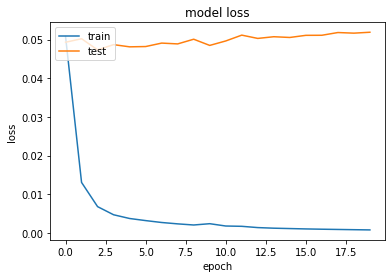

157/157 [==============================] - 0s 2ms/step - loss: 0.0519 - accuracy: 0.9856
accuracy after retraining: [0.051909320056438446, 0.9855999946594238]


In [ ]:
input_tensor1 = tf.keras.layers.Input(shape=(28, 28, 1), name = 'input')
model_1 = lenet5(input_tensor= input_tensor1)
model_1.load_weights('/content/drive/My Drive/deepxplore/models/lenet5.best.hdf5')
model_1.summary()
beval = model_1.evaluate(ds_test)
print("accuracy before retraining:", beval)
history=model_1.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_1.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Model: "LeNet-4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_14 (Averag (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 16)          1616      
_________________________________________________________________
average_pooling2d_15 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               3084

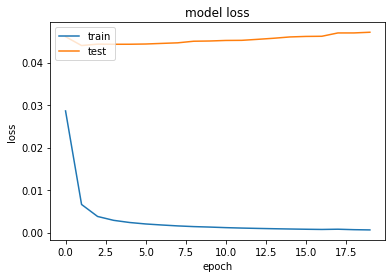

157/157 [==============================] - 0s 2ms/step - loss: 0.0471 - accuracy: 0.9859
accuracy after retraining: [0.04712876304984093, 0.9858999848365784]


In [ ]:
input_tensor2 = tf.keras.layers.Input(shape=(28, 28, 1), name = 'input')
model_2 = lenet4(input_tensor= input_tensor2)
model_2.load_weights('/content/drive/My Drive/deepxplore/models/lenet4.best.hdf5')
model_2.summary()
beval = model_2.evaluate(ds_test)
print("accuracy before retraining:", beval)
history=model_2.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_2.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Model: "LeNet-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_16 (Averag (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 12)          1212      
_________________________________________________________________
average_pooling2d_17 (Averag (None, 4, 4, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1930

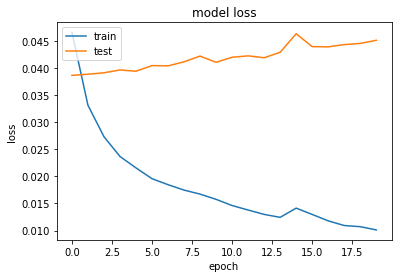

157/157 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9841
accuracy after retraining: [0.0451209582388401, 0.9840999841690063]


In [ ]:
input_tensor3 = tf.keras.layers.Input(shape=(28, 28, 1), name = 'input')
model_3 = lenet1(input_tensor= input_tensor3)
model_3.load_weights('/content/drive/My Drive/deepxplore/models/lenet1.best.hdf5')
model_3.summary()
beval = model_3.evaluate(ds_test)
print("accuracy before retraining:", beval)
history=model_3.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_3.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Light Transformation

In [ ]:
images, labels = load_images('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_light')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

Epoch 1/20
45/45 [==============================] - 1s 12ms/step - loss: 0.5667 - accuracy: 0.8713 - val_loss: 0.0865 - val_accuracy: 0.9751
Epoch 2/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.0834 - val_accuracy: 0.9768
Epoch 3/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0223 - accuracy: 0.9950 - val_loss: 0.0839 - val_accuracy: 0.9751
Epoch 4/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0145 - accuracy: 0.9979 - val_loss: 0.0828 - val_accuracy: 0.9764
Epoch 5/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0086 - accuracy: 0.9996 - val_loss: 0.0821 - val_accuracy: 0.9762
Epoch 6/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0072 - accuracy: 0.9996 - val_loss: 0.0814 - val_accuracy: 0.9764
Epoch 7/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0807 - val_accuracy: 0.9767
Epoch 8/20
45

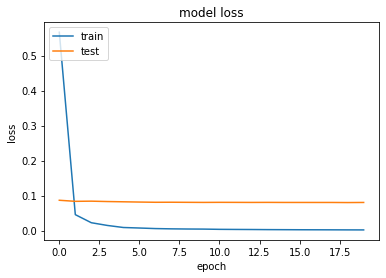

157/157 [==============================] - 0s 2ms/step - loss: 0.0802 - accuracy: 0.9770
accuracy after retraining: [0.08021628111600876, 0.9769999980926514]


In [ ]:
model_1.load_weights('/content/drive/My Drive/deepxplore/models/lenet5.best.hdf5')
history=model_1.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_1.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Epoch 1/20
45/45 [==============================] - 1s 12ms/step - loss: 0.7274 - accuracy: 0.8451 - val_loss: 0.0963 - val_accuracy: 0.9751
Epoch 2/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0992 - accuracy: 0.9681 - val_loss: 0.1037 - val_accuracy: 0.9722
Epoch 3/20
45/45 [==============================] - 1s 11ms/step - loss: 0.0363 - accuracy: 0.9876 - val_loss: 0.0997 - val_accuracy: 0.9734
Epoch 4/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0195 - accuracy: 0.9957 - val_loss: 0.0955 - val_accuracy: 0.9757
Epoch 5/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0133 - accuracy: 0.9993 - val_loss: 0.0939 - val_accuracy: 0.9755
Epoch 6/20
45/45 [==============================] - 1s 11ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0931 - val_accuracy: 0.9763
Epoch 7/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0923 - val_accuracy: 0.9762
Epoch 8/20
45

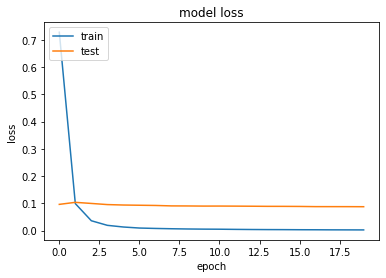

157/157 [==============================] - 0s 2ms/step - loss: 0.0877 - accuracy: 0.9768
accuracy after retraining: [0.0877072736620903, 0.9768000245094299]


In [ ]:
model_2.load_weights('/content/drive/My Drive/deepxplore/models/lenet4.best.hdf5')
history=model_2.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_2.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Epoch 1/20
45/45 [==============================] - 1s 12ms/step - loss: 1.3821 - accuracy: 0.7033 - val_loss: 0.0894 - val_accuracy: 0.9694
Epoch 2/20
45/45 [==============================] - 1s 11ms/step - loss: 0.3186 - accuracy: 0.8979 - val_loss: 0.0831 - val_accuracy: 0.9730
Epoch 3/20
45/45 [==============================] - 1s 11ms/step - loss: 0.2378 - accuracy: 0.9266 - val_loss: 0.0851 - val_accuracy: 0.9721
Epoch 4/20
45/45 [==============================] - 0s 11ms/step - loss: 0.2016 - accuracy: 0.9387 - val_loss: 0.0800 - val_accuracy: 0.9740
Epoch 5/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1824 - accuracy: 0.9436 - val_loss: 0.0790 - val_accuracy: 0.9743
Epoch 6/20
45/45 [==============================] - 0s 11ms/step - loss: 0.1639 - accuracy: 0.9504 - val_loss: 0.0806 - val_accuracy: 0.9742
Epoch 7/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1500 - accuracy: 0.9536 - val_loss: 0.0787 - val_accuracy: 0.9748
Epoch 8/20
45

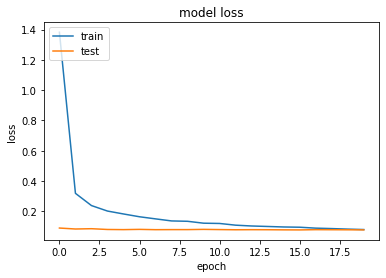

157/157 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.9753
accuracy after retraining: [0.07722461968660355, 0.9753000140190125]


In [ ]:
model_3.load_weights('/content/drive/My Drive/deepxplore/models/lenet1.best.hdf5')
history=model_3.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_3.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Occlusion Transformation

In [ ]:
images, labels = load_images('/content/drive/My Drive/deepxplore/train_set_generated/generated_inputs_occl')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

Epoch 1/20
1/1 [==============================] - 0s 408ms/step - loss: 0.6213 - accuracy: 0.7627 - val_loss: 0.0480 - val_accuracy: 0.9845
Epoch 2/20
1/1 [==============================] - 0s 405ms/step - loss: 0.1807 - accuracy: 0.9492 - val_loss: 0.0497 - val_accuracy: 0.9842
Epoch 3/20
1/1 [==============================] - 0s 403ms/step - loss: 0.0487 - accuracy: 0.9831 - val_loss: 0.0553 - val_accuracy: 0.9825
Epoch 4/20
1/1 [==============================] - 0s 409ms/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9803
Epoch 5/20
1/1 [==============================] - 0s 431ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 0.0739 - val_accuracy: 0.9782
Epoch 6/20
1/1 [==============================] - 0s 413ms/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.9729
Epoch 7/20
1/1 [==============================] - 0s 419ms/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9707
Epoch 8/20
1/1 [====

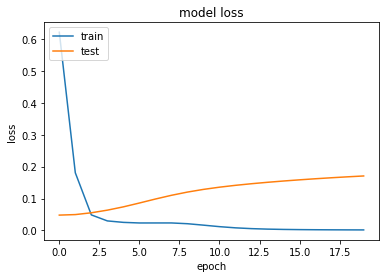

157/157 [==============================] - 0s 2ms/step - loss: 0.1707 - accuracy: 0.9518
accuracy after retraining: [0.17074008285999298, 0.9517999887466431]


In [ ]:
model_1.load_weights('/content/drive/My Drive/deepxplore/models/lenet5.best.hdf5')
history=model_1.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_1.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Epoch 1/20
1/1 [==============================] - 0s 395ms/step - loss: 0.2162 - accuracy: 0.8983 - val_loss: 0.0487 - val_accuracy: 0.9856
Epoch 2/20
1/1 [==============================] - 0s 395ms/step - loss: 0.1151 - accuracy: 0.9661 - val_loss: 0.0494 - val_accuracy: 0.9854
Epoch 3/20
1/1 [==============================] - 0s 414ms/step - loss: 0.0486 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 0.9848
Epoch 4/20
1/1 [==============================] - 0s 393ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9849
Epoch 5/20
1/1 [==============================] - 0s 388ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0537 - val_accuracy: 0.9844
Epoch 6/20
1/1 [==============================] - 0s 405ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0555 - val_accuracy: 0.9839
Epoch 7/20
1/1 [==============================] - 0s 407ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9836
Epoch 8/20
1/1 [====

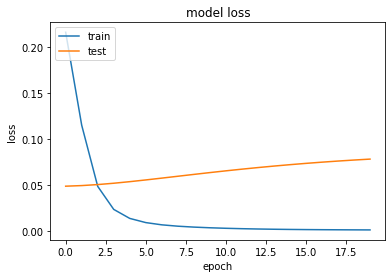

157/157 [==============================] - 0s 2ms/step - loss: 0.0782 - accuracy: 0.9781
accuracy after retraining: [0.07818945497274399, 0.9781000018119812]


In [ ]:
model_2.load_weights('/content/drive/My Drive/deepxplore/models/lenet4.best.hdf5')
history=model_2.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_2.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Epoch 1/20
1/1 [==============================] - 0s 392ms/step - loss: 0.1043 - accuracy: 0.9322 - val_loss: 0.0367 - val_accuracy: 0.9877
Epoch 2/20
1/1 [==============================] - 0s 397ms/step - loss: 0.0999 - accuracy: 0.9322 - val_loss: 0.0367 - val_accuracy: 0.9877
Epoch 3/20
1/1 [==============================] - 0s 381ms/step - loss: 0.0920 - accuracy: 0.9492 - val_loss: 0.0368 - val_accuracy: 0.9875
Epoch 4/20
1/1 [==============================] - 0s 386ms/step - loss: 0.0819 - accuracy: 0.9661 - val_loss: 0.0368 - val_accuracy: 0.9875
Epoch 5/20
1/1 [==============================] - 0s 375ms/step - loss: 0.0711 - accuracy: 0.9831 - val_loss: 0.0369 - val_accuracy: 0.9876
Epoch 6/20
1/1 [==============================] - 0s 385ms/step - loss: 0.0608 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 0.9876
Epoch 7/20
1/1 [==============================] - 0s 393ms/step - loss: 0.0518 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9874
Epoch 8/20
1/1 [====

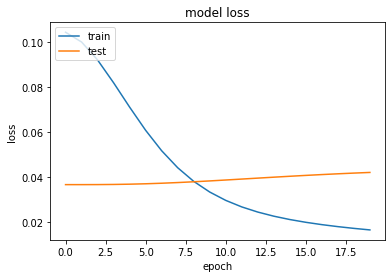

157/157 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9856
accuracy after retraining: [0.04214069992303848, 0.9855999946594238]


In [ ]:
model_3.load_weights('/content/drive/My Drive/deepxplore/models/lenet1.best.hdf5')
history=model_3.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_3.evaluate(ds_test)
print("accuracy after retraining:", aeval)

#Using examples generated from test set

Blackout Transformation

In [ ]:
images, labels = load_images('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_blackout')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d_18 (Averag (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_19 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               3084

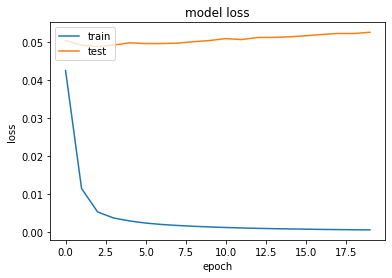

157/157 [==============================] - 0s 2ms/step - loss: 0.0526 - accuracy: 0.9868
accuracy after retraining: [0.0525854229927063, 0.9868000149726868]


In [ ]:
input_tensor1 = tf.keras.layers.Input(shape=(28, 28, 1), name = 'input')
model_1 = lenet5(input_tensor= input_tensor1)
model_1.load_weights('/content/drive/My Drive/deepxplore/models/lenet5.best.hdf5')
model_1.summary()
beval = model_1.evaluate(ds_test)
print("accuracy before retraining:", beval)
history=model_1.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_1.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Model: "LeNet-4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_20 (Averag (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 16)          1616      
_________________________________________________________________
average_pooling2d_21 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 120)               3084

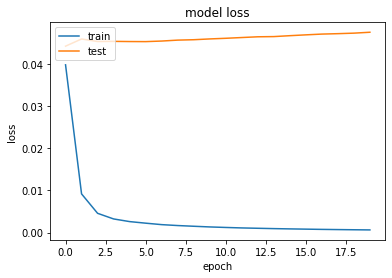

157/157 [==============================] - 0s 2ms/step - loss: 0.0475 - accuracy: 0.9857
accuracy after retraining: [0.047528691589832306, 0.9857000112533569]


In [ ]:
input_tensor2 = tf.keras.layers.Input(shape=(28, 28, 1), name = 'input')
model_2 = lenet4(input_tensor= input_tensor2)
model_2.load_weights('/content/drive/My Drive/deepxplore/models/lenet4.best.hdf5')
model_2.summary()
beval = model_2.evaluate(ds_test)
print("accuracy before retraining:", beval)
history=model_2.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_2.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Model: "LeNet-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_22 (Averag (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 12)          1212      
_________________________________________________________________
average_pooling2d_23 (Averag (None, 4, 4, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1930

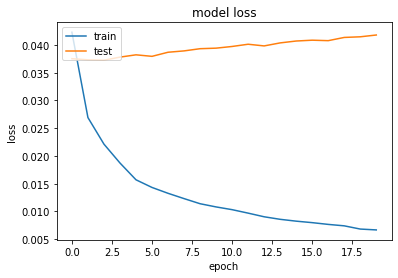

157/157 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 0.9860
accuracy after retraining: [0.041798196732997894, 0.9860000014305115]


In [ ]:
input_tensor3 = tf.keras.layers.Input(shape=(28, 28, 1), name = 'input')
model_3 = lenet1(input_tensor= input_tensor3)
model_3.load_weights('/content/drive/My Drive/deepxplore/models/lenet1.best.hdf5')
model_3.summary()
beval = model_3.evaluate(ds_test)
print("accuracy before retraining:", beval)
history=model_3.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_3.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Light Transformation

In [ ]:
images, labels = load_images('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_light')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

Epoch 1/20
45/45 [==============================] - 1s 12ms/step - loss: 0.4422 - accuracy: 0.8962 - val_loss: 0.0861 - val_accuracy: 0.9760
Epoch 2/20
45/45 [==============================] - 1s 13ms/step - loss: 0.0414 - accuracy: 0.9895 - val_loss: 0.0780 - val_accuracy: 0.9788
Epoch 3/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0159 - accuracy: 0.9976 - val_loss: 0.0728 - val_accuracy: 0.9799
Epoch 4/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 0.0713 - val_accuracy: 0.9802
Epoch 5/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0060 - accuracy: 0.9997 - val_loss: 0.0712 - val_accuracy: 0.9800
Epoch 6/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0706 - val_accuracy: 0.9800
Epoch 7/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0698 - val_accuracy: 0.9807
Epoch 8/20
45

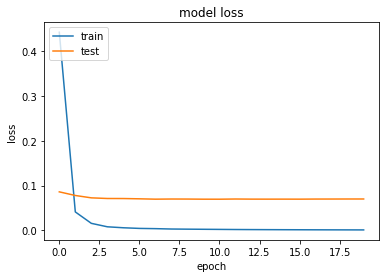

157/157 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9814
accuracy after retraining: [0.07021445780992508, 0.9814000129699707]


In [ ]:
model_1.load_weights('/content/drive/My Drive/deepxplore/models/lenet5.best.hdf5')
history=model_1.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_1.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Epoch 1/20
45/45 [==============================] - 1s 12ms/step - loss: 0.6283 - accuracy: 0.8647 - val_loss: 0.0883 - val_accuracy: 0.9768
Epoch 2/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0538 - accuracy: 0.9839 - val_loss: 0.0823 - val_accuracy: 0.9780
Epoch 3/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0290 - accuracy: 0.9934 - val_loss: 0.0804 - val_accuracy: 0.9783
Epoch 4/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0151 - accuracy: 0.9983 - val_loss: 0.0803 - val_accuracy: 0.9789
Epoch 5/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0104 - accuracy: 0.9986 - val_loss: 0.0812 - val_accuracy: 0.9795
Epoch 6/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0073 - accuracy: 0.9997 - val_loss: 0.0794 - val_accuracy: 0.9794
Epoch 7/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0776 - val_accuracy: 0.9804
Epoch 8/20
45

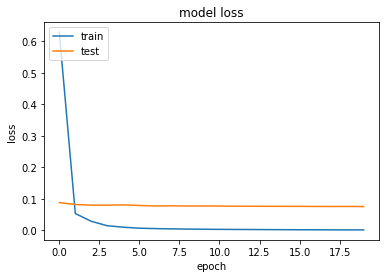

157/157 [==============================] - 0s 2ms/step - loss: 0.0760 - accuracy: 0.9805
accuracy after retraining: [0.07596100866794586, 0.9804999828338623]


In [ ]:
model_2.load_weights('/content/drive/My Drive/deepxplore/models/lenet4.best.hdf5')
history=model_2.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_2.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Epoch 1/20
45/45 [==============================] - 1s 11ms/step - loss: 1.2872 - accuracy: 0.7318 - val_loss: 0.0899 - val_accuracy: 0.9697
Epoch 2/20
45/45 [==============================] - 0s 11ms/step - loss: 0.2720 - accuracy: 0.9091 - val_loss: 0.0823 - val_accuracy: 0.9716
Epoch 3/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1965 - accuracy: 0.9357 - val_loss: 0.0787 - val_accuracy: 0.9743
Epoch 4/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1595 - accuracy: 0.9479 - val_loss: 0.0818 - val_accuracy: 0.9735
Epoch 5/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1374 - accuracy: 0.9566 - val_loss: 0.0794 - val_accuracy: 0.9740
Epoch 6/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1223 - accuracy: 0.9601 - val_loss: 0.0790 - val_accuracy: 0.9743
Epoch 7/20
45/45 [==============================] - 1s 12ms/step - loss: 0.1112 - accuracy: 0.9675 - val_loss: 0.0780 - val_accuracy: 0.9750
Epoch 8/20
45

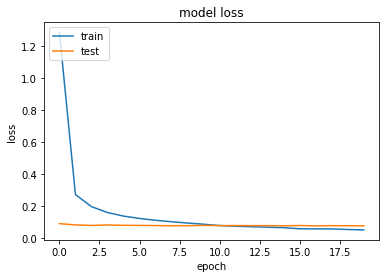

157/157 [==============================] - 0s 2ms/step - loss: 0.0765 - accuracy: 0.9762
accuracy after retraining: [0.07650557905435562, 0.9761999845504761]


In [ ]:
model_3.load_weights('/content/drive/My Drive/deepxplore/models/lenet1.best.hdf5')
history=model_3.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_3.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Occlusion Transformation

In [ ]:
images, labels = load_images('/content/drive/My Drive/deepxplore/test_set_generated/generated_inputs_occl')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

Epoch 1/20
1/1 [==============================] - 0s 399ms/step - loss: 0.7329 - accuracy: 0.6964 - val_loss: 0.0488 - val_accuracy: 0.9842
Epoch 2/20
1/1 [==============================] - 0s 410ms/step - loss: 0.1556 - accuracy: 0.9464 - val_loss: 0.0536 - val_accuracy: 0.9828
Epoch 3/20
1/1 [==============================] - 0s 410ms/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9789
Epoch 4/20
1/1 [==============================] - 0s 411ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9760
Epoch 5/20
1/1 [==============================] - 0s 392ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9702
Epoch 6/20
1/1 [==============================] - 0s 394ms/step - loss: 0.0336 - accuracy: 0.9821 - val_loss: 0.1213 - val_accuracy: 0.9649
Epoch 7/20
1/1 [==============================] - 0s 413ms/step - loss: 0.0330 - accuracy: 0.9821 - val_loss: 0.1415 - val_accuracy: 0.9584
Epoch 8/20
1/1 [====

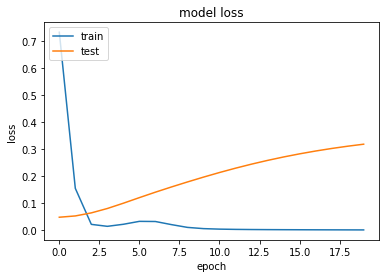

157/157 [==============================] - 0s 2ms/step - loss: 0.3189 - accuracy: 0.9212
accuracy after retraining: [0.31890439987182617, 0.9211999773979187]


In [ ]:
model_1.load_weights('/content/drive/My Drive/deepxplore/models/lenet5.best.hdf5')
history=model_1.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_1.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Epoch 1/20
1/1 [==============================] - 0s 394ms/step - loss: 0.2063 - accuracy: 0.8929 - val_loss: 0.0484 - val_accuracy: 0.9856
Epoch 2/20
1/1 [==============================] - 0s 401ms/step - loss: 0.0930 - accuracy: 0.9821 - val_loss: 0.0490 - val_accuracy: 0.9854
Epoch 3/20
1/1 [==============================] - 0s 395ms/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9854
Epoch 4/20
1/1 [==============================] - 0s 392ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.0516 - val_accuracy: 0.9850
Epoch 5/20
1/1 [==============================] - 0s 394ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 0.9845
Epoch 6/20
1/1 [==============================] - 0s 385ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0548 - val_accuracy: 0.9841
Epoch 7/20
1/1 [==============================] - 0s 398ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9835
Epoch 8/20
1/1 [====

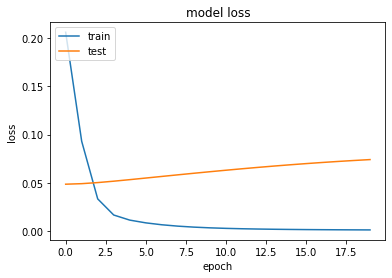

157/157 [==============================] - 0s 2ms/step - loss: 0.0740 - accuracy: 0.9784
accuracy after retraining: [0.0740165188908577, 0.9783999919891357]


In [ ]:
model_2.load_weights('/content/drive/My Drive/deepxplore/models/lenet4.best.hdf5')
history=model_2.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_2.evaluate(ds_test)
print("accuracy after retraining:", aeval)

Epoch 1/20
1/1 [==============================] - 0s 400ms/step - loss: 0.0566 - accuracy: 0.9821 - val_loss: 0.0367 - val_accuracy: 0.9879
Epoch 2/20
1/1 [==============================] - 0s 376ms/step - loss: 0.0552 - accuracy: 0.9821 - val_loss: 0.0365 - val_accuracy: 0.9882
Epoch 3/20
1/1 [==============================] - 0s 375ms/step - loss: 0.0524 - accuracy: 0.9821 - val_loss: 0.0364 - val_accuracy: 0.9881
Epoch 4/20
1/1 [==============================] - 0s 399ms/step - loss: 0.0486 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 0.9881
Epoch 5/20
1/1 [==============================] - 0s 373ms/step - loss: 0.0442 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 0.9878
Epoch 6/20
1/1 [==============================] - 0s 390ms/step - loss: 0.0398 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 0.9880
Epoch 7/20
1/1 [==============================] - 0s 383ms/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 0.9882
Epoch 8/20
1/1 [====

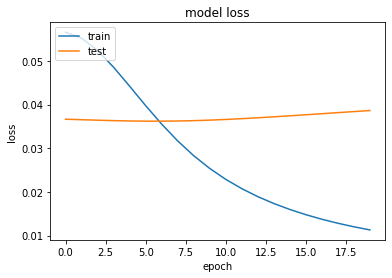

157/157 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9871
accuracy after retraining: [0.038643304258584976, 0.9871000051498413]


In [ ]:
model_3.load_weights('/content/drive/My Drive/deepxplore/models/lenet1.best.hdf5')
history=model_3.fit(tf.divide(tf.cast(images, tf.float32), tf.constant(255.0)), labels, batch_size, epochs=20, validation_data=ds_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
aeval = model_3.evaluate(ds_test)
print("accuracy after retraining:", aeval)